# Imports

In [1]:
import colorsys
import json
import warnings
from collections import Counter, defaultdict
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pycocotools.mask as mask_utils
import seaborn as sns
from PIL import Image

warnings.filterwarnings("ignore")
plt.style.use("seaborn-v0_8")
sns.set_palette("husl")

%matplotlib inline

# Constants

In [2]:
COCO_JSON_PATH = Path(
    "/Volumes/T7 Shield/vlxlab/cps/data/cps_vlx_iter1_with_images/annotations/instances_default2.json"
)
IMAGES_DIR = Path("/Volumes/T7 Shield/vlxlab/cps/data/cps_vlx_iter1_with_images/images/default")
MAX_IMAGES_TO_SHOW = 12

assert COCO_JSON_PATH.is_file()
assert IMAGES_DIR.is_dir()

# Helper functions

In [3]:
def decode_segmentation(
    segmentation: list[list[float]] | dict, height: int, width: int
) -> np.ndarray | None:
    """Decode COCO segmentation format to binary mask.

    Args:
        segmentation (list[list[float]] | dict): COCO segmentation (RLE or polygon format).
        height (int): Image height.
        width (int): Image width.

    Returns:
        np.ndarray | None: Binary mask as numpy array or `None` if unsupported segmentation format provided.
    """

    if isinstance(segmentation, list):  # Polygon format
        from PIL import Image, ImageDraw

        mask = Image.new("L", (width, height), 0)
        draw = ImageDraw.Draw(mask)
        for polygon in segmentation:
            polygon_points = [(polygon[i], polygon[i + 1]) for i in range(0, len(polygon), 2)]
            draw.polygon(polygon_points, fill=1)
        return np.array(mask)
    elif isinstance(segmentation, dict):  # RLE format
        mask = mask_utils.decode(segmentation)
        return mask
    else:
        return None


def create_colormap(cat_id_to_name: dict[int, str]) -> dict:
    """Create colormap for visualization.

    Args:
        cat_id_to_name (dict[int, str]): Mapping from category ID to its name.

    Returns:
        dict: Mapping from category ID to corresponding color.
    """

    colors_dict = {}

    # Use HSV color space to generate maximally distinct colors
    hsv_colors = []
    for i in range(len(cat_id_to_name)):
        hue = i / len(cat_id_to_name)
        saturation = 0.7 + (i % 3) * 0.1
        value = 0.8 + (i % 2) * 0.2
        hsv_colors.append([hue, saturation, value])
    colors = []
    for hsv in hsv_colors:
        rgb = colorsys.hsv_to_rgb(hsv[0], hsv[1], hsv[2])
        colors.append(rgb + (1.0,))  # Add alpha channel
    colors = np.array(colors)
    for i, cat_id in enumerate(cat_id_to_name.keys()):
        colors_dict[cat_id] = colors[i % len(colors)]

    return colors_dict

# Data loading

In [4]:
with open(COCO_JSON_PATH) as f:
    coco_data = json.load(f)

print(
    f"Loaded COCO data with {len(coco_data['images'])} images, "
    f"{len(coco_data['annotations'])} annotations, "
    f"{len(coco_data['categories'])} categories"
)

img_id_to_info = {img["id"]: img for img in coco_data["images"]}
cat_id_to_name = {cat["id"]: cat for cat in coco_data["categories"]}
annotations = coco_data["annotations"]

Loaded COCO data with 499 images, 16323 annotations, 32 categories


# Car parts masks visualization

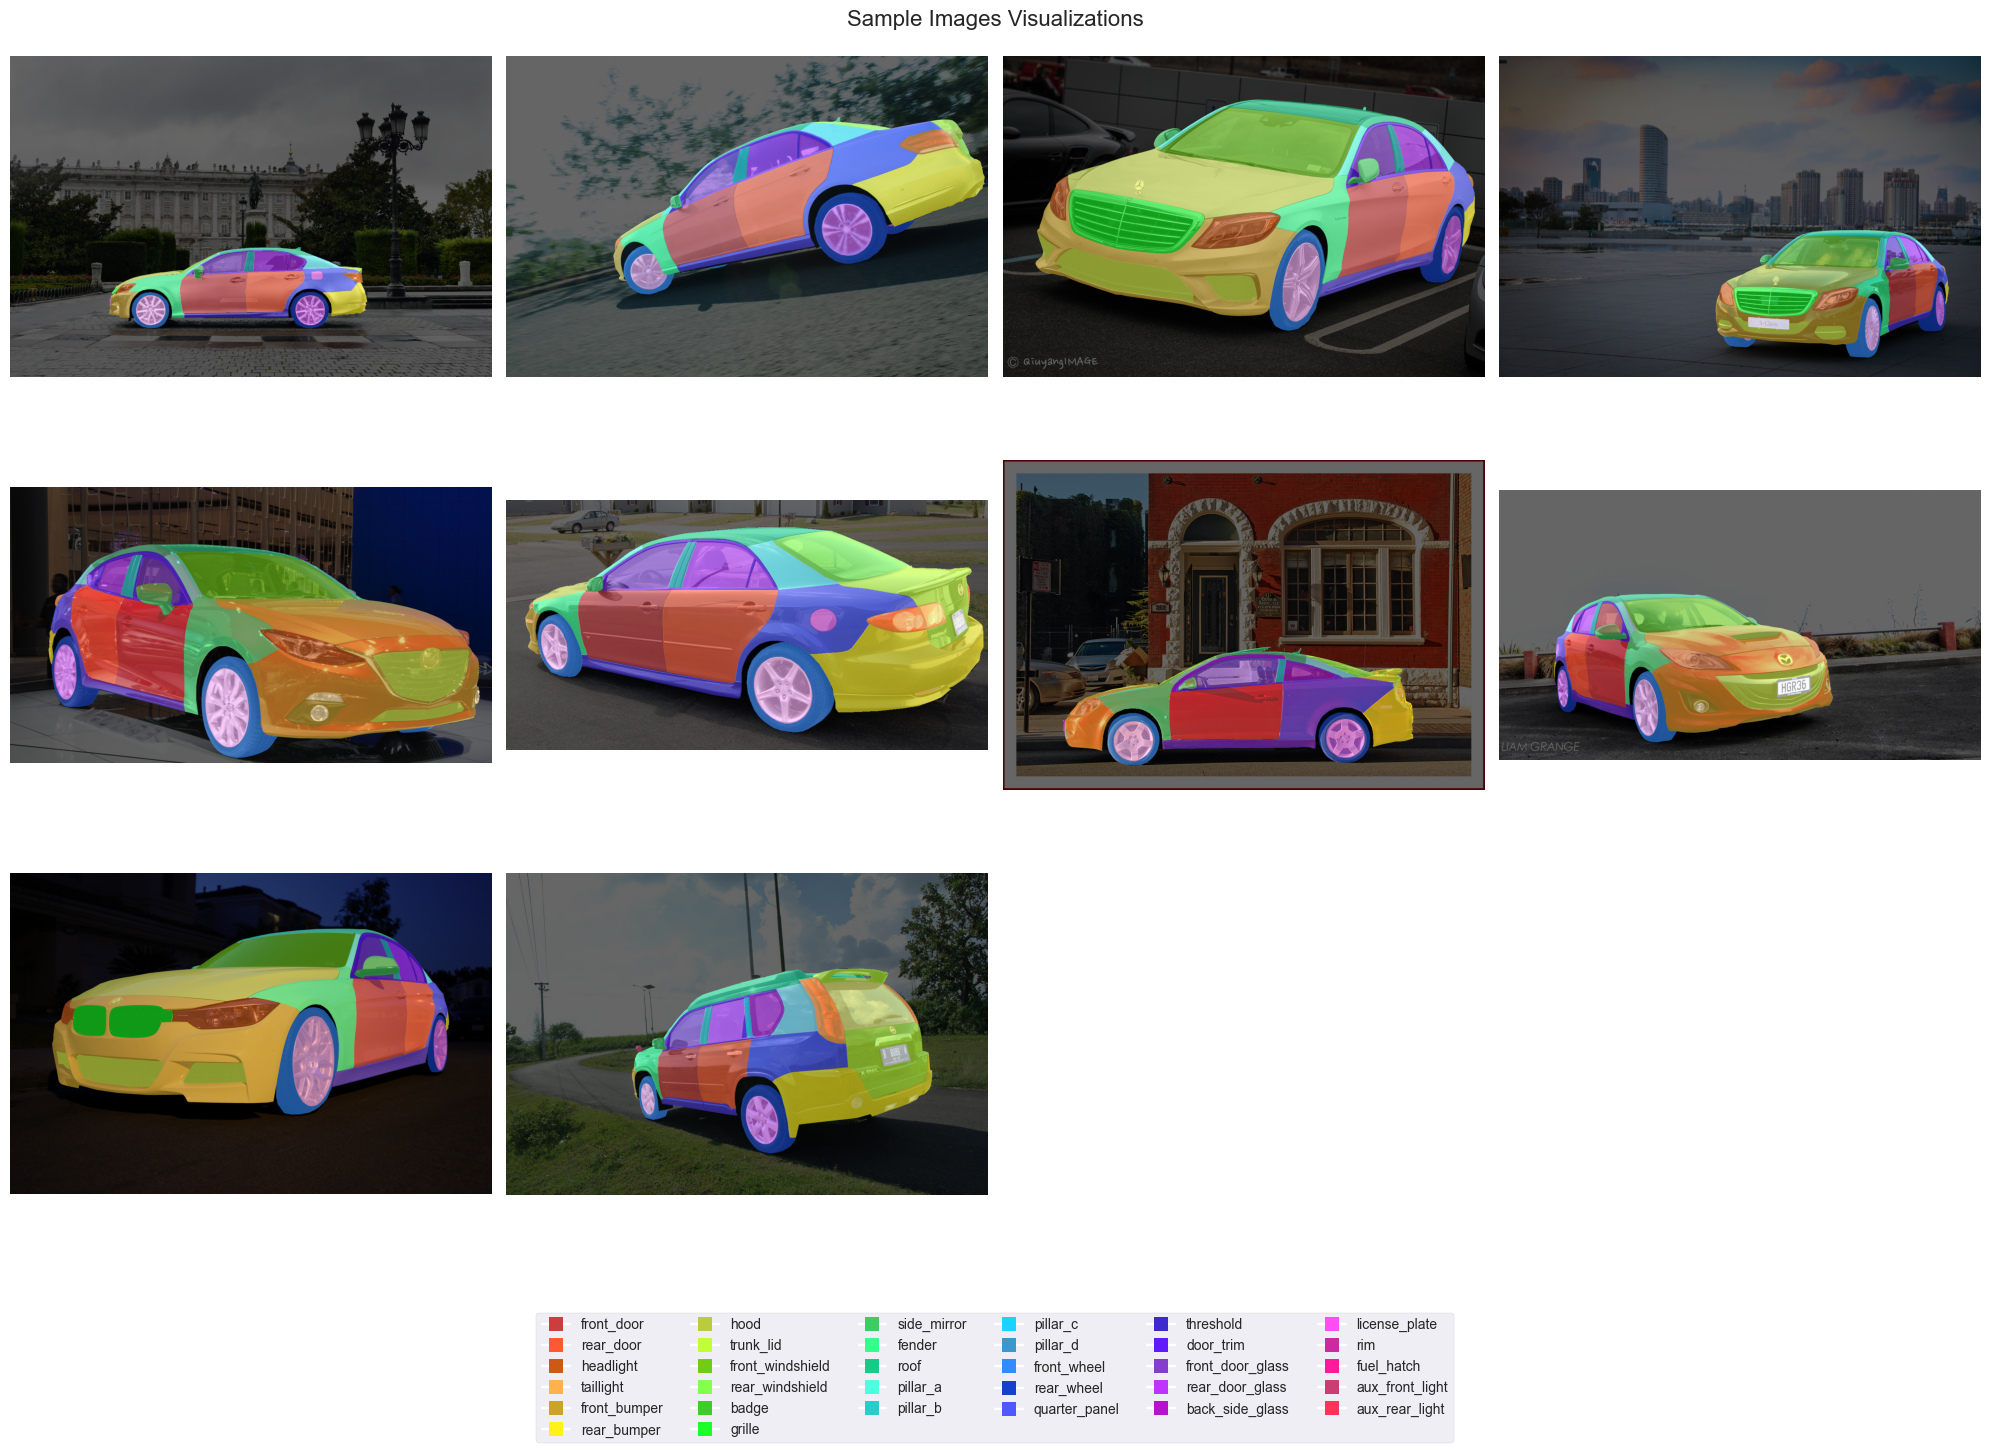

In [5]:
colors_dict = create_colormap(cat_id_to_name)

# Group annotations by image
image_annotations = defaultdict(list)
for ann in annotations:
    image_annotations[ann["image_id"]].append(ann)

# Select images ensuring all classes are represented
classes_shown = set()
selected_images = []

# First, select images that have the most diverse classes
for img_id, anns in image_annotations.items():
    if len(selected_images) >= MAX_IMAGES_TO_SHOW:
        break
    img_classes = {ann["category_id"] for ann in anns}
    new_classes = img_classes - classes_shown
    if new_classes or len(classes_shown) < len(cat_id_to_name):
        selected_images.append(img_id)
        classes_shown.update(img_classes)

# If we still haven't shown all classes, add more images
remaining_classes = set(cat_id_to_name.keys()) - classes_shown
if remaining_classes and len(selected_images) < MAX_IMAGES_TO_SHOW:
    for img_id, anns in image_annotations.items():
        if img_id in selected_images:
            continue
        img_classes = {ann["category_id"] for ann in anns}
        if img_classes & remaining_classes:
            selected_images.append(img_id)
            classes_shown.update(img_classes)
            remaining_classes -= img_classes
            if len(selected_images) >= MAX_IMAGES_TO_SHOW or not remaining_classes:
                break

n_images = len(selected_images)
cols = min(4, n_images)
rows = (n_images + cols - 1) // cols
fig, axes = plt.subplots(rows, cols, figsize=(20, 5 * rows))
axes = axes.flatten()
for i, img_id in enumerate(selected_images):
    if i >= len(axes):
        break
    ax = axes[i]
    img_info = img_id_to_info[img_id]
    img_path = f"{IMAGES_DIR}/{img_info['file_name']}"
    img = Image.open(img_path)
    ax.imshow(img)

    # Create combined mask for all annotations in this image
    combined_mask = np.zeros((img_info["height"], img_info["width"], 3))

    # Draw all segmentation masks with their respective colors
    for ann in image_annotations[img_id]:
        mask = decode_segmentation(ann["segmentation"], img_info["height"], img_info["width"])
        cat_id = ann["category_id"]
        color = colors_dict[cat_id][:3]  # RGB only

        # Add colored mask
        for c in range(3):
            combined_mask[:, :, c] += mask * color[c]
    combined_mask = np.clip(combined_mask, 0, 1)
    ax.imshow(combined_mask, alpha=0.6)
    ax.axis("off")

for i in range(len(selected_images), len(axes)):
    axes[i].axis("off")
plt.tight_layout()

# Create legend
legend_elements = []
for cat_id in sorted(cat_id_to_name.keys()):
    if cat_id in classes_shown:
        cat_name = cat_id_to_name[cat_id]["name"]
        color = colors_dict[cat_id]
        legend_elements.append(
            plt.Line2D(
                [0],
                [0],
                marker="s",
                color="w",
                markerfacecolor=color,
                markersize=10,
                label=cat_name,
            )
        )

fig.legend(
    handles=legend_elements,
    loc="lower center",
    bbox_to_anchor=(0.5, 0.02),
    ncol=min(6, len(legend_elements)),
    fontsize=10,
    frameon=True,
)
plt.suptitle("Sample Images Visualizations", fontsize=16, y=0.98)
plt.subplots_adjust(bottom=0.15)
plt.show()

# Class distribution analysis

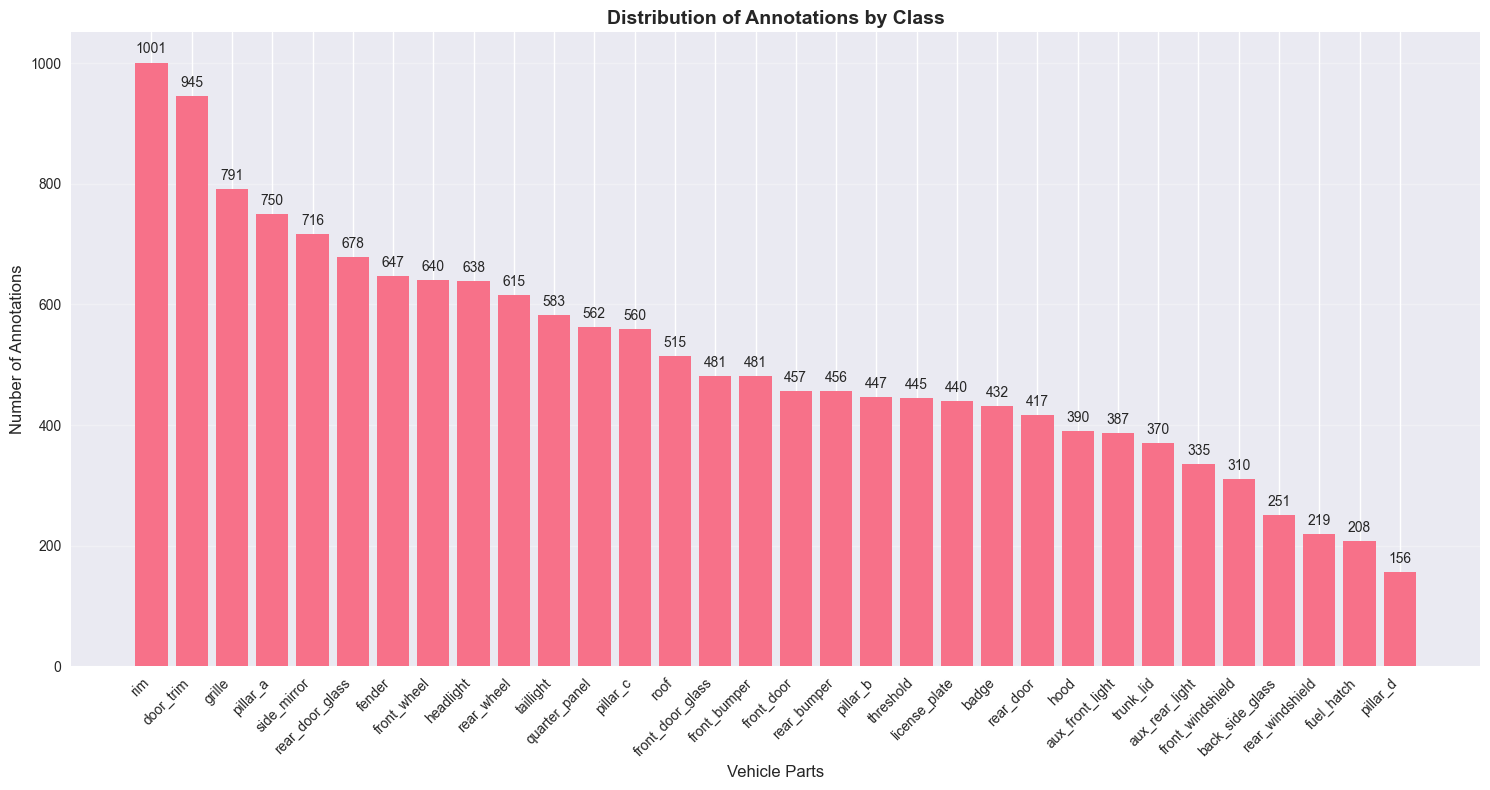

Total annotations: 16323
Most common class: rim (1001 annotations)
Least common class: pillar_d (156 annotations)


In [6]:
category_counts = Counter(ann["category_id"] for ann in annotations)
categories_names = []
counts = []
for cat_id, count in category_counts.most_common():
    categories_names.append(cat_id_to_name[cat_id]["name"])
    counts.append(count)

plt.figure(figsize=(15, 8))
bars = plt.bar(range(len(categories_names)), counts)
for bar, count in zip(bars, counts, strict=False):
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height() + max(counts) * 0.01,
        str(count),
        ha="center",
        va="bottom",
        fontsize=10,
    )
plt.xlabel("Vehicle Parts", fontsize=12)
plt.ylabel("Number of Annotations", fontsize=12)
plt.title("Distribution of Annotations by Class", fontsize=14, fontweight="bold")
plt.xticks(range(len(categories_names)), categories_names, rotation=45, ha="right")
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Total annotations: {sum(counts)}")
print(f"Most common class: {categories_names[0]} ({counts[0]} annotations)")
print(f"Least common class: {categories_names[-1]} ({counts[-1]} annotations)")

# Images dimensions analysis

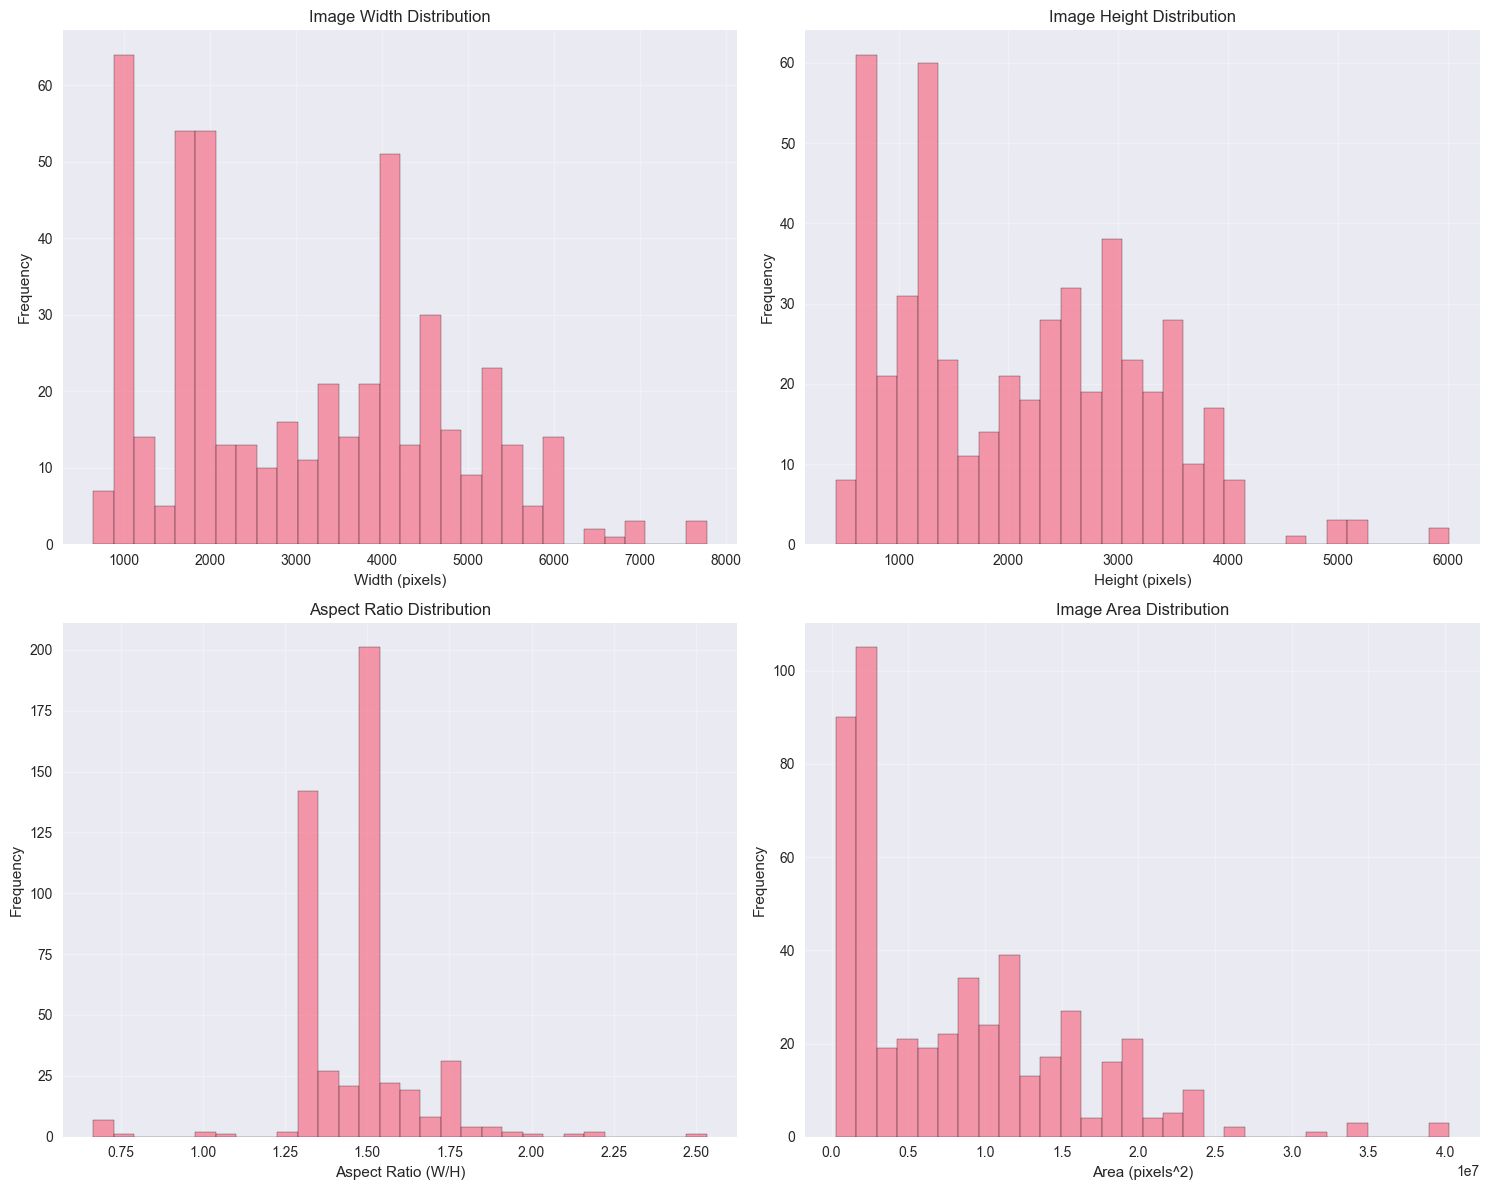

Image dimensions statistics:
Width - Mean: 3092.0, Std: 1607.2
Height - Mean: 2124.7, Std: 1108.3
Aspect Ratio - Mean: 1.47, Std: 0.19
Area - Mean: 8263128, Std: 7483094


In [7]:
widths = [img["width"] for img in img_id_to_info.values()]
heights = [img["height"] for img in img_id_to_info.values()]
aspect_ratios = [w / h for w, h in zip(widths, heights, strict=False)]
areas = [w * h for w, h in zip(widths, heights, strict=False)]
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Width distribution
axes[0, 0].hist(widths, bins=30, alpha=0.7, edgecolor="black")
axes[0, 0].set_xlabel("Width (pixels)")
axes[0, 0].set_ylabel("Frequency")
axes[0, 0].set_title("Image Width Distribution")
axes[0, 0].grid(alpha=0.3)

# Height distribution
axes[0, 1].hist(heights, bins=30, alpha=0.7, edgecolor="black")
axes[0, 1].set_xlabel("Height (pixels)")
axes[0, 1].set_ylabel("Frequency")
axes[0, 1].set_title("Image Height Distribution")
axes[0, 1].grid(alpha=0.3)

# Aspect ratio distribution
axes[1, 0].hist(aspect_ratios, bins=30, alpha=0.7, edgecolor="black")
axes[1, 0].set_xlabel("Aspect Ratio (W/H)")
axes[1, 0].set_ylabel("Frequency")
axes[1, 0].set_title("Aspect Ratio Distribution")
axes[1, 0].grid(alpha=0.3)

# Area distribution
axes[1, 1].hist(areas, bins=30, alpha=0.7, edgecolor="black")
axes[1, 1].set_xlabel("Area (pixels^2)")
axes[1, 1].set_ylabel("Frequency")
axes[1, 1].set_title("Image Area Distribution")
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("Image dimensions statistics:")
print(f"Width - Mean: {np.mean(widths):.1f}, Std: {np.std(widths):.1f}")
print(f"Height - Mean: {np.mean(heights):.1f}, Std: {np.std(heights):.1f}")
print(f"Aspect Ratio - Mean: {np.mean(aspect_ratios):.2f}, Std: {np.std(aspect_ratios):.2f}")
print(f"Area - Mean: {np.mean(areas):.0f}, Std: {np.std(areas):.0f}")

# Objects sizes analysis

32 32


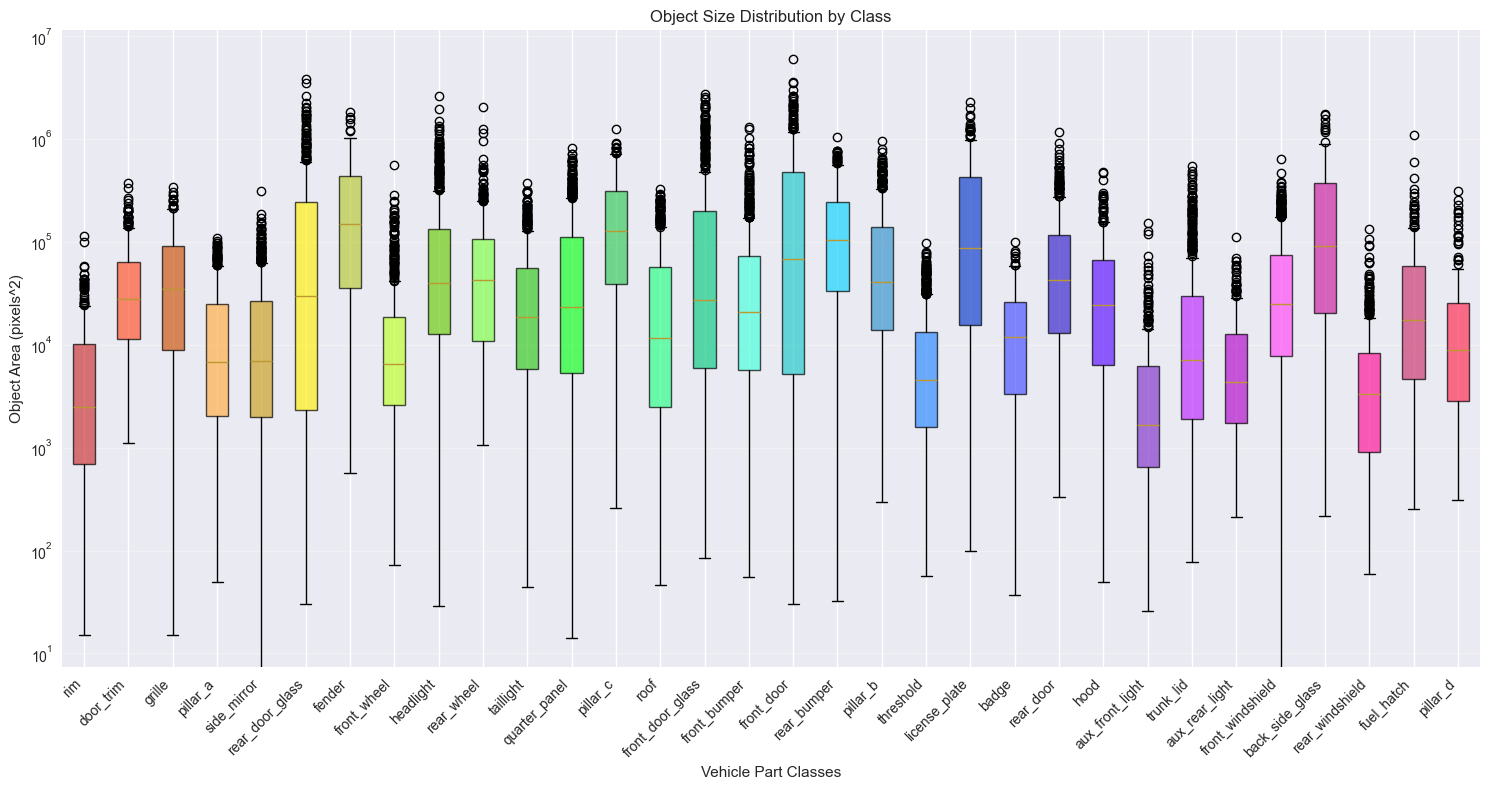

Object size statistics by class:
           Class  Count  Mean Area  Median Area  Std Area  Min Area  Max Area
    front_bumper    481   363882.3      68759.0  628323.6      30.0 5972166.0
front_windshield    310   274050.0     149925.0  308362.6     571.0 1855396.0
            hood    390   267013.3      87655.0  366051.0      99.0 2273640.0
       trunk_lid    370   259691.1      29747.5  508931.1      30.0 3807930.0
     rear_bumper    456   250019.2      27046.0  486897.5      84.0 2747595.0
 rear_windshield    219   235214.7      91267.0  321853.2     215.0 1758474.0
      front_door    457   206643.7     129063.0  209030.3     259.0 1268954.0
       rear_door    417   171222.9     105513.0  178895.7      32.0 1045132.0
   quarter_panel    562   142326.4      40254.5  260545.1      29.0 2635351.0
     front_wheel    640   108994.7      40522.0  148353.5     298.0  965662.0
      rear_wheel    615    95148.9      42684.0  133156.0     331.0 1162745.0
          fender    647    9068

In [8]:
category_areas = defaultdict(list)
for ann in annotations:
    if "area" in ann:
        category_areas[ann["category_id"]].append(ann["area"])
    elif "bbox" in ann:
        bbox = ann["bbox"]
        area = bbox[2] * bbox[3]
        category_areas[ann["category_id"]].append(area)

areas_data = [areas for areas in category_areas.values() if areas]

# Create box plot
plt.figure(figsize=(15, 8))
print(len(areas_data), len(categories_names))
box_plot = plt.boxplot(areas_data, labels=categories_names, patch_artist=True)
for patch, color in zip(box_plot["boxes"], colors_dict.values(), strict=False):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)
plt.xlabel("Vehicle Part Classes")
plt.ylabel("Object Area (pixels^2)")
plt.title("Object Size Distribution by Class")
plt.xticks(rotation=45, ha="right")
plt.yscale("log")  # Log scale for better visualization
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

print("Object size statistics by class:")
stats_data = []
for cat_id, areas in category_areas.items():
    if areas:
        cat_name = cat_id_to_name[cat_id]["name"]
        stats_data.append(
            {
                "Class": cat_name,
                "Count": len(areas),
                "Mean Area": np.mean(areas),
                "Median Area": np.median(areas),
                "Std Area": np.std(areas),
                "Min Area": min(areas),
                "Max Area": max(areas),
            }
        )

df_stats = pd.DataFrame(stats_data)
df_stats = df_stats.sort_values("Mean Area", ascending=False)
print(df_stats.to_string(index=False, float_format="%.1f"))